# set environment

In [1]:
import numpy as np
import pandas as pd
import os, re
import pickle
from   numba import jit, njit
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

##############################################################
FP_LGG = "/data/Duke_BIOS824/LGG-segmentation/"
FP_OUT = "/data/Duke_BIOS824/res_proj01/"
FP_FIG = "/home/clint/GitRepo/Duke_BIOS824_Proj1/fig/"
patients = [x for x in os.listdir(FP_LGG) if "TCGA" in x]    

In [2]:
%matplotlib inline

# load data

In [3]:
fp = open(FP_OUT + 'img_slice.pickle', 'rb')
img_slice = pickle.load(fp)
fp.close()

In [4]:
fp = open(FP_OUT + 'img_mask.pickle', 'rb')
img_mask = pickle.load(fp)
fp.close()

check dimension

In [5]:
print(len(img_slice))
print(len(img_mask))
print(img_slice['TCGA_CS_4941_19960909'].shape)
print(img_mask[ 'TCGA_CS_4941_19960909'].shape)

110
110
(256, 256, 23, 3)
(256, 256, 23)


In [6]:
print(img_slice['TCGA_CS_4941_19960909'][:, :, 1:, :].shape)

(256, 256, 22, 3)


# Number of slices for each patient

In [7]:
dat = np.array([
    img_mask[pat].shape[2] for pat in patients
])
print(dat)

[23 20 20 20 20 20 24 22 25 24 20 24 26 28 22 38 40 36 36 36 26 36 71 38
 53 57 51 53 58 56 52 58 49 60 36 38 34 32 36 36 35 36 36 40 37 37 37 36
 36 37 36 38 38 35 56 23 31 36 20 60 42 24 32 30 51 26 36 48 60 48 26 27
 51 48 60 50 36 73 32 20 32 28 30 21 25 20 24 20 21 21 21 32 22 20 28 80
 32 20 20 32 22 20 22 21 22 23 32 28 88 88]


# Remove the first slices

In [8]:
### init
tmp_slice = dict()
tmp_mask  = dict()

### remove first slice
for pat, img in img_slice.items():
    tmp_slice[pat] = img[:, :, 1:, :]

for pat, mask in img_mask.items():
    tmp_mask[pat] = mask[:, :, 1:]

# Where are the slices containing tumors?

helper function

In [9]:
get_idx  = lambda arr: np.where(arr)[0]
is_tumor = lambda img: np.any(img > 0)
is_seq   = lambda arr: np.all((arr[1:] - arr[:-1])  == 1)

def show_arr(arr):
    if len(arr) > 3:
        return str(arr[0]) + " " + str(arr[1]) + " ... " + str(arr[-1])
    else:
        return str(arr[0]) + " " + str(arr[1]) + " " + str(arr[2]) 

get the index of tumor slices

In [10]:
dct = dict()

for pat in patients:
    ### choose patient
    mask = tmp_mask[pat]
    
    ### get the mask with tumor
    dct[pat] = np.array([is_tumor(mask[:, :, idx]) for idx in range(mask.shape[2])])

summarize and observe the indices

In [11]:
df = [(pat,
       is_seq(get_idx(val)), 
       len(val), val.sum(), show_arr(get_idx(val)), 
       np.ceil(np.median(get_idx(val))).astype(np.int)
      ) for pat, val in dct.items()]

df = pd.DataFrame(df, columns=[
    "Patient",
    "Is_consecutive", 
    "N_slides_tot", "N_slides_tumors", "Index_slides_tumors", 
    "Index_median"])

df['Index_lw'] = df['Index_median'] - 20
df['Index_up'] = df['Index_median'] + 20

df_img_summary = df

In [12]:
print(np.all(df.Is_consecutive))
print("Min:", np.min(df.N_slides_tumors), "; Max:", np.max(df.N_slides_tumors))

True
Min: 3 ; Max: 37


**Here I decided to take 40 as the dimension of all the input**

Text(0,0.5,'Number of slices contain tumor')

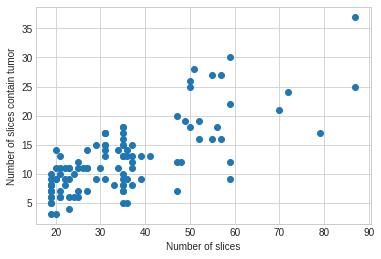

In [13]:
plt.scatter(df.N_slides_tot, df.N_slides_tumors)
plt.xlabel("Number of slices")
plt.ylabel("Number of slices contain tumor")

In [14]:
df_img_summary.head()

,Patient,Is_consecutive,N_slides_tot,N_slides_tumors,Index_slides_tumors,Index_median,Index_lw,Index_up
0,TCGA_CS_4941_19960909,True,22,8,9 10 ... 16,13,-7,33
1,TCGA_CS_4942_19970222,True,19,6,7 8 ... 12,10,-10,30
2,TCGA_CS_4943_20000902,True,19,8,10 11 ... 17,14,-6,34
3,TCGA_CS_4944_20010208,True,19,9,4 5 ... 12,8,-12,28
4,TCGA_CS_5393_19990606,True,19,8,3 4 ... 10,7,-13,27


# Apply mask on images and Normalization

filtered the image based on mask

In [15]:
img_filtered = dict()

for pat in patients:
    img  = tmp_slice[pat].copy()
    mask = tmp_mask[pat].copy()
    mask = mask > 100
    
    img[:, :, :, 0] *= mask
    img[:, :, :, 1] *= mask
    img[:, :, :, 2] *= mask
    
    ### normalization (don't norm here because it is too larged to store
    #img = (img - np.min(img)) / (np.max(img) - np.min(img))
    img_filtered[pat] = img

check dimension

In [16]:
pat = patients[0]

print(len(img_slice))
print(img_slice[pat].shape)

print(len(tmp_slice))
print(tmp_slice[pat].shape)

print(len(img_filtered))
print(img_filtered[pat].shape)
print(img_filtered[pat].min(), img_filtered[pat].max(), )

110
(256, 256, 23, 3)
110
(256, 256, 22, 3)
110
(256, 256, 22, 3)
0 211


helper function

In [17]:
def filled_blank(img, n_front, n_back):
    """add blank images and extend on both sides"""
    ### copy the images
    img = img.copy()
    
    ### set up blank images to the front
    img_blank = np.zeros(shape=(256, 256, n_front, 3))
    img = np.concatenate([img_blank, img], axis=2)
       
    ### set up blank images to the back
    img_blank = np.zeros(shape=(256, 256, n_back,  3))
    img = np.concatenate([img, img_blank], axis=2)
    
    return img

filled the images to make the dimension equals across the patients

In [18]:
### declare & init
N_IMG_FINAL = 40
img_filtered_fill = dict()

### for each patient
for pat in patients:
    
    ### choose mask from patient
    mask = tmp_mask[pat]
    
    ### get the mask with tumor
    idx = np.array([is_tumor(mask[:, :, idx]) for idx in range(mask.shape[2])])
    
    ### get the image
    img = img_filtered[pat].copy()
    print("shape of the image:", img.shape)
    
    ### filtered out all images without tumor
    img = img[:, :, idx, :]
    print("After filtered:    ", img.shape)
    
    ### make all the image into 40
    idx1 = (N_IMG_FINAL - idx.sum()) / 2
    idx2 = (N_IMG_FINAL - idx.sum()) / 2
    idx1 = np.floor(idx1).astype(np.int)
    idx2 = np.ceil( idx2).astype(np.int)
    img = filled_blank(img, idx1, idx2).astype(np.uint8)
    
    ### store the results
    img_filtered_fill[pat] = img
    print("After filling:     ", img.shape)
    
    ### check if the tumor is at the center
    idx = np.array([is_tumor(img[:, :, idx, 0]) for idx in range(img.shape[2])])
    print("Check Results:     ", idx.sum(), np.median(np.where(idx)[0]))
    print("===============================")

shape of the image: (256, 256, 22, 3)
After filtered:     (256, 256, 8, 3)
After filling:      (256, 256, 40, 3)
Check Results:      8 19.5
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 6, 3)
After filling:      (256, 256, 40, 3)
Check Results:      6 19.5
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 8, 3)
After filling:      (256, 256, 40, 3)
Check Results:      8 19.5
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 9, 3)
After filling:      (256, 256, 40, 3)
Check Results:      9 19.0
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 8, 3)
After filling:      (256, 256, 40, 3)
Check Results:      8 19.5
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 3, 3)
After filling:      (256, 256, 40, 3)
Check Results:      3 19.0
shape of the image: (256, 256, 23, 3)
After filtered:     (256, 256, 11, 3)
After filling:      (256, 256, 40, 3)
Check Results:      11 19.0
shape of the image

After filling:      (256, 256, 40, 3)
Check Results:      13 19.0
shape of the image: (256, 256, 36, 3)
After filtered:     (256, 256, 14, 3)
After filling:      (256, 256, 40, 3)
Check Results:      14 19.5
shape of the image: (256, 256, 35, 3)
After filtered:     (256, 256, 15, 3)
After filling:      (256, 256, 40, 3)
Check Results:      15 19.0
shape of the image: (256, 256, 37, 3)
After filtered:     (256, 256, 12, 3)
After filling:      (256, 256, 40, 3)
Check Results:      12 19.5
shape of the image: (256, 256, 37, 3)
After filtered:     (256, 256, 15, 3)
After filling:      (256, 256, 40, 3)
Check Results:      15 19.0
shape of the image: (256, 256, 34, 3)
After filtered:     (256, 256, 14, 3)
After filling:      (256, 256, 40, 3)
Check Results:      14 19.5
shape of the image: (256, 256, 55, 3)
After filtered:     (256, 256, 16, 3)
After filling:      (256, 256, 40, 3)
Check Results:      16 19.5
shape of the image: (256, 256, 22, 3)
After filtered:     (256, 256, 11, 3)
After 

Check Results:      7 19.0
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 5, 3)
After filling:      (256, 256, 40, 3)
Check Results:      5 19.0
shape of the image: (256, 256, 31, 3)
After filtered:     (256, 256, 17, 3)
After filling:      (256, 256, 40, 3)
Check Results:      17 19.0
shape of the image: (256, 256, 21, 3)
After filtered:     (256, 256, 13, 3)
After filling:      (256, 256, 40, 3)
Check Results:      13 19.0
shape of the image: (256, 256, 19, 3)
After filtered:     (256, 256, 7, 3)
After filling:      (256, 256, 40, 3)
Check Results:      7 19.0
shape of the image: (256, 256, 21, 3)
After filtered:     (256, 256, 7, 3)
After filling:      (256, 256, 40, 3)
Check Results:      7 19.0
shape of the image: (256, 256, 20, 3)
After filtered:     (256, 256, 9, 3)
After filling:      (256, 256, 40, 3)
Check Results:      9 19.0
shape of the image: (256, 256, 21, 3)
After filtered:     (256, 256, 11, 3)
After filling:      (256, 256, 40, 3)
Check Results: 

# Check and Visualization

check results

In [19]:
pat  = patients[0]
img  = tmp_slice[pat]
imgf1 = img_filtered[pat]
imgf2 = img_filtered_fill[pat]
imgn = (imgf1 - np.min(imgf1)) / (np.max(imgf1) - np.min(imgf1))
print(img[80:86, 83:90, 10, 0])
print("-----------")
print(imgf1[80:86, 83:90, 10, 0])
print("-----------")
print(imgf2[80:86, 83:90, 17, 0])
print("-----------")
print(imgn[80:86, 83:90, 10, 0])

[[56 48 45 55 64 61 58]
 [59 56 52 55 59 58 58]
 [58 55 57 61 61 59 59]
 [57 57 58 59 58 58 56]
 [58 57 57 56 57 59 58]
 [61 60 56 57 60 60 57]]
-----------
[[ 0  0  0  0 64 61 58]
 [ 0  0  0  0 59 58 58]
 [ 0  0  0  0 61 59 59]
 [ 0  0  0  0 58 58 56]
 [58 57 57 56 57 59 58]
 [61 60 56 57 60 60 57]]
-----------
[[ 0  0  0  0 64 61 58]
 [ 0  0  0  0 59 58 58]
 [ 0  0  0  0 61 59 59]
 [ 0  0  0  0 58 58 56]
 [58 57 57 56 57 59 58]
 [61 60 56 57 60 60 57]]
-----------
[[0.         0.         0.         0.         0.30331754 0.28909953
  0.27488152]
 [0.         0.         0.         0.         0.27962085 0.27488152
  0.27488152]
 [0.         0.         0.         0.         0.28909953 0.27962085
  0.27962085]
 [0.         0.         0.         0.         0.27488152 0.27488152
  0.26540284]
 [0.27488152 0.27014218 0.27014218 0.26540284 0.27014218 0.27962085
  0.27488152]
 [0.28909953 0.28436019 0.26540284 0.27014218 0.28436019 0.28436019
  0.27014218]]


reason why not storing the normalized array

In [20]:
print(img.dtype)
print(imgf1.dtype)
print(imgf2.dtype)
print(imgn.dtype)
print("--------------")
print(img.nbytes)
print(imgf1.nbytes)
print(imgf2.nbytes)
print(imgn.nbytes)

uint8
uint8
uint8
float64
--------------
4325376
4325376
7864320
34603008


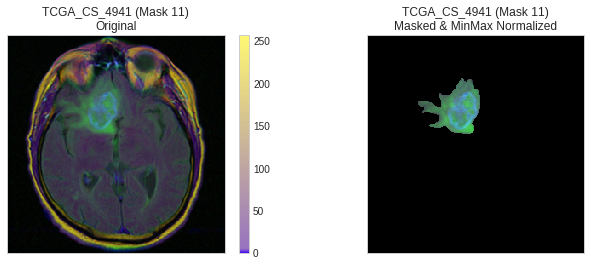

In [21]:
cdict = {
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))
}
cm = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (11, 4))
ax = axes[0]
cax = ax.imshow(img[:,:,10], cmap = cm, vmin=0, vmax=256)
ax.set_title("TCGA_CS_4941 (Mask 11)\nOriginal")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(cax, ax=ax)

ax = axes[1]
cax = ax.imshow(imgn[:,:,10], cmap = cm, vmin=0, vmax=1)
ax.set_title("TCGA_CS_4941 (Mask 11)\nMasked & MinMax Normalized")
ax.set_xticks([]); ax.set_yticks([])
#plt.colorbar(cax, ax=ax)

### store images
fname = FP_FIG + "img_filtered_TCGA_CS_4941.png"
plt.savefig(fname, dpi = 300)
pass

# Store

In [22]:
print(len(img_slice))
print(len(img_filtered))
print(len(img_filtered_fill))

110
110
110


In [23]:
for pat in img_slice.keys():
    img = img_slice[pat]
    print(pat, img.shape)
    
    img = img_filtered[pat]
    print(pat, img.shape)
    
    img = img_filtered_fill[pat]
    print(pat, img.shape)
    print("======================")

TCGA_CS_4941_19960909 (256, 256, 23, 3)
TCGA_CS_4941_19960909 (256, 256, 22, 3)
TCGA_CS_4941_19960909 (256, 256, 40, 3)
TCGA_CS_4942_19970222 (256, 256, 20, 3)
TCGA_CS_4942_19970222 (256, 256, 19, 3)
TCGA_CS_4942_19970222 (256, 256, 40, 3)
TCGA_CS_4943_20000902 (256, 256, 20, 3)
TCGA_CS_4943_20000902 (256, 256, 19, 3)
TCGA_CS_4943_20000902 (256, 256, 40, 3)
TCGA_CS_4944_20010208 (256, 256, 20, 3)
TCGA_CS_4944_20010208 (256, 256, 19, 3)
TCGA_CS_4944_20010208 (256, 256, 40, 3)
TCGA_CS_5393_19990606 (256, 256, 20, 3)
TCGA_CS_5393_19990606 (256, 256, 19, 3)
TCGA_CS_5393_19990606 (256, 256, 40, 3)
TCGA_CS_5395_19981004 (256, 256, 20, 3)
TCGA_CS_5395_19981004 (256, 256, 19, 3)
TCGA_CS_5395_19981004 (256, 256, 40, 3)
TCGA_CS_5396_20010302 (256, 256, 24, 3)
TCGA_CS_5396_20010302 (256, 256, 23, 3)
TCGA_CS_5396_20010302 (256, 256, 40, 3)
TCGA_CS_5397_20010315 (256, 256, 22, 3)
TCGA_CS_5397_20010315 (256, 256, 21, 3)
TCGA_CS_5397_20010315 (256, 256, 40, 3)
TCGA_CS_6186_20000601 (256, 256, 25, 3)


In [24]:
with open(FP_OUT + 'img_filtered.pickle', 'wb') as fp:
    pickle.dump(img_filtered, fp)
fp.close()

with open(FP_OUT + 'img_filtered_fill.pickle', 'wb') as fp:
    pickle.dump(img_filtered_fill, fp)
fp.close()

In [25]:
!ls -l /data/Duke_BIOS824/res_proj01/

total 2584056
-rwxrwxrwx 1 clint clint    119487 Apr  1 21:30 df_img_area_perimeter.csv
-rwxrwxrwx 1 clint clint 865085256 Apr  8 03:00 img_filtered_fill.pickle
-rwxrwxrwx 1 clint clint 750856008 Apr  8 03:00 img_filtered.pickle
-rwxrwxrwx 1 clint clint 257500670 Apr  8 02:02 img_mask.pickle
-rwxrwxrwx 1 clint clint 772482888 Apr  8 02:02 img_slice.pickle
-rwxrwxrwx 1 clint clint      2132 Apr  6 15:17 label.csv
-rwxrwxrwx 1 clint clint      8502 Apr  6 15:17 label_split.csv
